# Baseline Movie: Goldilocks Under Seed 42

**Purpose:** Record W[t] at every step to create a "movie" of embedding evolution.

This is our control—the canonical Goldilocks run that we'll analyze from every angle.
No hypothesis, just observation. Get to know the organism.

| Property | Value |
|----------|-------|
| Architecture | Rich (4L/128D/2H/256FF) |
| Learning rate | **3e-4** (realistic range) |
| Steps | 10,000 |
| Seed | 42 |
| Output | `W_movie.safetensors` — W[t] at every step |

**Storage budget:** 10K steps × [3988 × 128] × 2 bytes (bf16) ≈ 10 GB

---

*Jeffery Harrell & Alpha, December 1, 2025*

## Parameters

In [1]:
import torch

# Paths
GOLDILOCKS_DATA = "../Goldilocks/data"
TOKENIZER_PATH = f"{GOLDILOCKS_DATA}/tokenizer.json"
TOKENS_PATH = f"{GOLDILOCKS_DATA}/model_corpus_tokens.safetensors"
CENSUS_PATH = f"{GOLDILOCKS_DATA}/token_census.json"

# Output
OUTPUT_PATH = "W_movie.safetensors"

# Architecture: Rich (unchanged)
N_LAYERS = 4
D_MODEL = 128
N_HEADS = 2
D_FF = 256
SEQ_LEN = 128
DROPOUT = 0.0

# Training — MODIFIED from reference
BATCH_SIZE = 8
LEARNING_RATE = 3e-4  # Realistic range (was 1e-3)
NUM_STEPS = 10_000
MODEL_DTYPE = torch.bfloat16

# Reproducibility
RANDOM_SEED = 42

## Imports & Device

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from safetensors.torch import load_file, save_file
from tokenizers import Tokenizer
import json
import time
import numpy as np
from tqdm.auto import tqdm

torch.manual_seed(RANDOM_SEED)

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Device: {device}")
print(f"Dtype: {MODEL_DTYPE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Steps: {NUM_STEPS:,}")

Device: mps
Dtype: torch.bfloat16
Learning rate: 0.0003
Steps: 10,000


## Load Data

In [3]:
tokenizer = Tokenizer.from_file(TOKENIZER_PATH)
vocab_size = tokenizer.get_vocab_size()
print(f"✓ Tokenizer: {vocab_size:,} tokens")

tokens_data = load_file(TOKENS_PATH)
all_tokens = tokens_data["tokens"].to(torch.long)
print(f"✓ Corpus: {len(all_tokens):,} tokens")

with open(CENSUS_PATH, 'r') as f:
    census = json.load(f)
dead_token_ids = set(census['dead_token_ids'])
n_dead = len(dead_token_ids)
n_live = vocab_size - n_dead

# Create masks for easy indexing
dead_mask = torch.zeros(vocab_size, dtype=torch.bool)
for tid in dead_token_ids:
    dead_mask[tid] = True
live_mask = ~dead_mask

print(f"✓ Dead tokens: {n_dead:,}")
print(f"✓ Live tokens: {n_live:,}")

✓ Tokenizer: 3,988 tokens
✓ Corpus: 34,993,926 tokens
✓ Dead tokens: 1,914
✓ Live tokens: 2,074


## Dataset & Model

In [4]:
class TokenDataset(Dataset):
    def __init__(self, tokens, seq_len, num_samples=100_000):
        self.tokens = tokens
        self.seq_len = seq_len
        self.num_samples = num_samples
        max_start = len(tokens) - seq_len - 1
        self.starts = torch.randint(0, max_start, (num_samples,))
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        start = self.starts[idx]
        chunk = self.tokens[start:start + self.seq_len + 1]
        return chunk[:-1], chunk[1:]

dataset = TokenDataset(all_tokens, SEQ_LEN)
print(f"✓ Dataset: {len(dataset):,} samples")

✓ Dataset: 100,000 samples


In [5]:
class GPT(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, n_layers, d_ff, seq_len, dropout=0.0):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(seq_len, d_model)
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_model, nhead=n_heads, dim_feedforward=d_ff,
                dropout=dropout, activation='gelu', batch_first=True, norm_first=True
            ) for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)
        self.head.weight = self.tok_emb.weight
        self.seq_len = seq_len
        self.register_buffer('causal_mask', None)
        self._init_weights()
    
    def _init_weights(self):
        """N(0, 0.02) for token embeddings — matches Qwen."""
        with torch.no_grad():
            self.tok_emb.weight.copy_(torch.randn(self.tok_emb.weight.shape) * 0.02)
    
    def forward(self, x):
        B, T = x.shape
        if self.causal_mask is None or self.causal_mask.shape[0] != T:
            self.causal_mask = torch.triu(
                torch.ones(T, T, device=x.device, dtype=torch.bool), diagonal=1
            )
        pos = torch.arange(T, device=x.device)
        h = self.tok_emb(x) + self.pos_emb(pos)
        for layer in self.layers:
            h = layer(h, src_mask=self.causal_mask, is_causal=True)
        return self.head(self.ln_f(h))

model = GPT(
    vocab_size=vocab_size,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    n_layers=N_LAYERS,
    d_ff=D_FF,
    seq_len=SEQ_LEN,
    dropout=DROPOUT
).to(device).to(MODEL_DTYPE)

n_params = sum(p.numel() for p in model.parameters())
print(f"✓ Model: {n_params:,} parameters")

✓ Model: 1,057,024 parameters


In [6]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

print(f"✓ Optimizer: AdamW (lr={LEARNING_RATE})")
print(f"✓ Tokens per step: {BATCH_SIZE * SEQ_LEN:,}")

✓ Optimizer: AdamW (lr=0.0003)
✓ Tokens per step: 1,024


## Storage Estimate

In [7]:
# W is [vocab_size × D_MODEL] in bfloat16 (2 bytes)
W_size_bytes = vocab_size * D_MODEL * 2
total_bytes = W_size_bytes * (NUM_STEPS + 1)  # +1 for initial state

print(f"W shape: [{vocab_size:,} × {D_MODEL}]")
print(f"W size per step: {W_size_bytes / 1e6:.2f} MB")
print(f"Total movie size: {total_bytes / 1e9:.2f} GB")

W shape: [3,988 × 128]
W size per step: 1.02 MB
Total movie size: 10.21 GB


## Training Loop with Recording

Accumulate W[t] in RAM, save once at the end. Much faster than streaming to disk.

In [8]:
model.train()
loader_iter = iter(loader)

# Pre-allocate the movie tensor in RAM
# Shape: [num_steps+1, vocab_size, d_model] in bfloat16
W_movie = torch.zeros(NUM_STEPS + 1, vocab_size, D_MODEL, dtype=torch.bfloat16)
losses = []

# Record initial state (step 0)
W_movie[0] = model.tok_emb.weight.detach().cpu().to(torch.bfloat16)

print(f"W_movie shape: {W_movie.shape}")
print(f"W_movie size: {W_movie.numel() * 2 / 1e9:.2f} GB")
print()
print(f"Training {NUM_STEPS:,} steps...")
print()

start_time = time.time()

for step in tqdm(range(1, NUM_STEPS + 1)):
    # Get batch
    try:
        x, y = next(loader_iter)
    except StopIteration:
        loader_iter = iter(loader)
        x, y = next(loader_iter)
    
    x, y = x.to(device), y.to(device)
    
    # Forward/backward
    optimizer.zero_grad()
    logits = model(x)
    loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
    loss.backward()
    optimizer.step()
    
    # Record (just a tensor copy, no disk I/O)
    losses.append(loss.item())
    W_movie[step] = model.tok_emb.weight.detach().cpu().to(torch.bfloat16)
    
    # Progress update every 1000 steps
    if step % 1000 == 0:
        elapsed = time.time() - start_time
        steps_per_sec = step / elapsed
        tqdm.write(f"Step {step:,}: loss={loss.item():.4f}, {steps_per_sec:.1f} steps/sec")

elapsed = time.time() - start_time

print()
print(f"Training done! {NUM_STEPS:,} steps in {elapsed:.1f}s ({NUM_STEPS/elapsed:.1f} steps/sec)")
print(f"Final loss: {losses[-1]:.4f}")

W_movie shape: torch.Size([10001, 3988, 128])
W_movie size: 10.21 GB

Training 10,000 steps...



  0%|          | 0/10000 [00:00<?, ?it/s]

Step 1,000: loss=6.7812, 98.2 steps/sec
Step 2,000: loss=6.7500, 99.4 steps/sec
Step 3,000: loss=6.6562, 98.9 steps/sec
Step 4,000: loss=6.7500, 99.3 steps/sec
Step 5,000: loss=6.7500, 99.1 steps/sec
Step 6,000: loss=6.7188, 99.0 steps/sec
Step 7,000: loss=6.6562, 97.4 steps/sec
Step 8,000: loss=6.7188, 97.4 steps/sec
Step 9,000: loss=6.7500, 97.7 steps/sec
Step 10,000: loss=6.7500, 97.5 steps/sec

Training done! 10,000 steps in 102.5s (97.5 steps/sec)
Final loss: 6.7500


## Save to Disk

In [9]:
# Save W movie and metadata to safetensors
print(f"Saving to {OUTPUT_PATH}...")

save_dict = {
    "W": W_movie,  # [num_steps+1, vocab_size, d_model]
    "losses": torch.tensor(losses, dtype=torch.float32),
    "dead_mask": dead_mask,
}

save_file(save_dict, OUTPUT_PATH)

import os
file_size = os.path.getsize(OUTPUT_PATH)
print(f"Done! File size: {file_size / 1e9:.2f} GB")

Saving to W_movie.safetensors...
Done! File size: 10.21 GB


## Save Model Checkpoint

In [10]:
# Save full model checkpoint for generation testing
MODEL_PATH = "model.safetensors"

# Collect all model parameters
model_state = {k: v.cpu() for k, v in model.state_dict().items()}

save_file(model_state, MODEL_PATH)

model_size = os.path.getsize(MODEL_PATH)
print(f"✓ Saved model checkpoint: {MODEL_PATH} ({model_size / 1e6:.2f} MB)")
print(f"  Keys: {list(model_state.keys())[:5]}... ({len(model_state)} total)")

✓ Saved model checkpoint: model.safetensors (3.16 MB)
  Keys: ['causal_mask', 'tok_emb.weight', 'pos_emb.weight', 'layers.0.self_attn.in_proj_weight', 'layers.0.self_attn.in_proj_bias']... (54 total)


In [11]:
## Quick Sanity Check

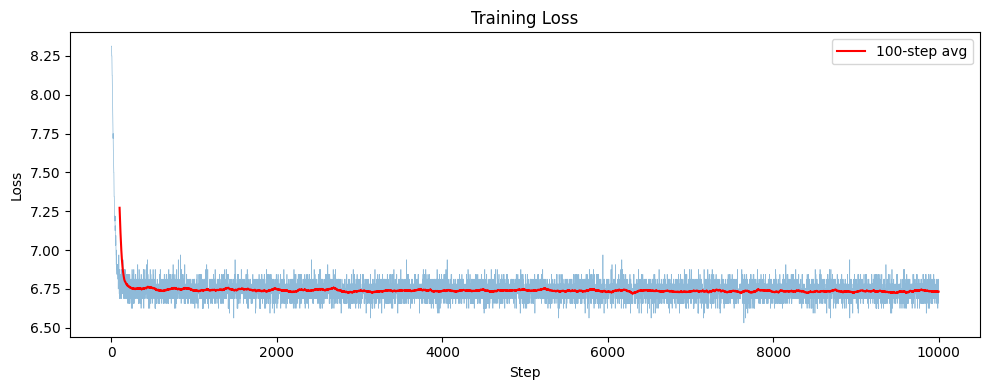

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(losses, alpha=0.5, linewidth=0.5)
# Smoothed version
window = 100
if len(losses) > window:
    smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')
    ax.plot(range(window-1, len(losses)), smoothed, 'r-', linewidth=1.5, label=f'{window}-step avg')
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.set_title('Training Loss')
ax.legend()
plt.tight_layout()
plt.savefig('01_baseline_movie_loss.png', dpi=150)
plt.show()